In [14]:
import findspark
findspark.init()
import pandas as pd
from pyspark.sql.functions import col, explode
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
import time

### Initiate spark session

In [3]:
from pyspark.sql import SparkSession
sc = SparkContext
# sc.setCheckpointDir('checkpoint')
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

# 1. Load data

In [9]:
data0 = spark.read.csv("/home/ksn38/data/transaction_data.csv", header=True)
data0 = data0.toDF(*[col.lower() for col in data0.columns])
data0 = data0.withColumnRenamed('product_id','item_id').withColumnRenamed('household_key','user_id')
data0.show(3)

+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
|user_id|  basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|trans_time|week_no|coupon_disc|coupon_match_disc|
+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
|   2375|26984851472|  1|1004906|       1|       1.39|     364|       -0.6|      1631|      1|          0|                0|
|   2375|26984851472|  1|1033142|       1|       0.82|     364|          0|      1631|      1|          0|                0|
|   2375|26984851472|  1|1036325|       1|       0.99|     364|       -0.3|      1631|      1|          0|                0|
+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
only showing top 3 rows



In [10]:
data0.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- basket_id: string (nullable = true)
 |-- day: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- sales_value: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- retail_disc: string (nullable = true)
 |-- trans_time: string (nullable = true)
 |-- week_no: string (nullable = true)
 |-- coupon_disc: string (nullable = true)
 |-- coupon_match_disc: string (nullable = true)



In [12]:
data0 = data0.\
    withColumn('user_id', col('user_id').cast('integer')).\
    withColumn('basket_id', col('basket_id').cast('integer')).\
    withColumn('day', col('day').cast('integer')).\
    withColumn('item_id', col('item_id').cast('integer')).\
    withColumn('quantity', col('quantity').cast('integer')).\
    withColumn('sales_value', col('sales_value').cast('float')).\
    withColumn('store_id', col('store_id').cast('integer')).\
    withColumn('retail_disc', col('retail_disc').cast('float')).\
    withColumn('week_no', col('week_no').cast('integer')).\
    withColumn('coupon_disc', col('coupon_disc').cast('integer')).\
    withColumn('coupon_match_disc', col('coupon_match_disc').cast('float')).\
    drop('trans_time')
data0.show(3)

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|   2375|     null|  1|1004906|       1|       1.39|     364|       -0.6|      1|          0|              0.0|
|   2375|     null|  1|1033142|       1|       0.82|     364|        0.0|      1|          0|              0.0|
|   2375|     null|  1|1036325|       1|       0.99|     364|       -0.3|      1|          0|              0.0|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
only showing top 3 rows



In [14]:
data0.describe().show()

+-------+------------------+---------+------------------+-----------------+--------+------------------+-----------------+-------------------+------------------+--------------------+--------------------+
|summary|           user_id|basket_id|               day|          item_id|quantity|       sales_value|         store_id|        retail_disc|           week_no|         coupon_disc|   coupon_match_disc|
+-------+------------------+---------+------------------+-----------------+--------+------------------+-----------------+-------------------+------------------+--------------------+--------------------+
|  count|           2595732|        0|           2595732|          2595732| 2595732|           2595732|          2595732|            2595732|           2595732|             2595732|             2595732|
|   mean|1271.9525170549193|     null| 388.7562217517063|2891435.159594673|     1.0|3.1041197828967073|3142.673210870768|-0.5387053984379715|56.221498983716344|-0.01199122251449...|-0.0029

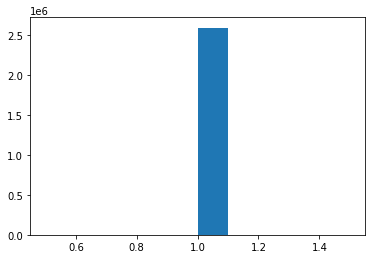

In [15]:
import matplotlib.pyplot as plt

quantity_arr = [int(x.quantity) for x in data0.select('quantity').collect()]
plt.hist(quantity_arr)
plt.show()

In [9]:
# week_no_arr = [int(x.week_no) for x in data.select('week_no').collect()]
# plt.hist(week_no_arr)
# plt.show()

In [15]:
data = data0.withColumn('quantity', F.when(F.col("quantity") != 1, 1).otherwise(F.col("quantity")))

## Calculate sparsity

In [17]:
# Count the total number of data in the dataset
numerator = data1.select("quantity").count()
print('numerator', numerator)

# Count the number of distinct userIds and distinct movieIds
num_users = data1.select("user_id").distinct().count()
num_items = data1.select("item_id").distinct().count()
print('num_users', num_users)
print('num_items', num_items)

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_items
print('denominator', denominator)

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The data dataframe is ", "%.2f" % sparsity + "% empty.")

numerator 2595732
num_users 2500
num_items 92339
denominator 230847500
The data dataframe is  98.88% empty.


## Interpret ratings

## Build Out An ALS Model

In [17]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [19]:
# data_quntitiy_1 = data0.withColumn('quantity', F.when(F.col("quantity") != 1, 1).otherwise(F.col("quantity")))
# stages = []
# stages += [data_quntitiy_1]

# # Create test and train set
# train = data.select('*').where(col('week_no') < 95)
# test = data.select('*').where(col('week_no') >= 95)

# # Create ALS model
# als = ALS(userCol="user_id", itemCol="item_id", ratingCol="quantity", nonnegative = True, implicitPrefs = True, coldStartStrategy="drop")

# stages += [als]

# # evaluator = RegressionEvaluator(metricName="rmse", labelCol="quantity", predictionCol="prediction") 

# # model = als.fit(train)

# # View the predictions
# # test_predictions = model.transform(test)
# # RMSE = evaluator.evaluate(test_predictions)
# # print(RMSE)

# pipeline = Pipeline().setStages(stages)
# pipelineModel = pipeline.fit(data)

# #сохраняем модель на HDFS
# pipelineModel.write().overwrite().save("/home/ksn38/models/als_pipline")

In [10]:
pipeline_model = PipelineModel.load("/home/ksn38/models/als_pipline")
predict = pipeline_model.transform(data)
predict.show()

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+------------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc|  prediction|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+------------+
|   2375|     null|  1|1004906|       1|       1.39|     364|       -0.6|      1|          0|              0.0|   1.0375035|
|   2375|     null|  1|1033142|       1|       0.82|     364|        0.0|      1|          0|              0.0|  0.84694946|
|   2375|     null|  1|1036325|       1|       0.99|     364|       -0.3|      1|          0|              0.0|  0.15830791|
|   2375|     null|  1|1082185|       1|       1.21|     364|        0.0|      1|          0|              0.0|   1.4255048|
|   2375|     null|  1|8160430|       1|        1.5|     364|      -0.39|      1|          0|              0.0|   0.1046671|


In [18]:
# Create test and train set
train = data.select('*').where(col('week_no') < 95)
test = data.select('*').where(col('week_no') >= 95)

# Create ALS model
als = ALS(userCol="user_id", itemCol="item_id", ratingCol="quantity", nonnegative = True, implicitPrefs = True, coldStartStrategy="drop")

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

In [18]:
test.count()

227995

## Tell Spark how to tune your ALS model

In [15]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="quantity", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


## Build your cross validation pipeline

In [16]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Confirm cv was built
print(cv)

CrossValidator_21b7e9f6ee28


## Best Model and Best Model Parameters

In [17]:
import time

t1 = time.time()

In [18]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [19]:
time.time() - t1

10333.542170524597

In [20]:

# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

# # Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 150
  MaxIter: 10
  RegParam: 0.1


In [21]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.6947972112878122


In [22]:
test_predictions.show()

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+-----------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc| prediction|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+-----------+
|   1001|     null|671| 201946|       1|        2.0|    3131|        0.0|     97|          0|              0.0| 0.23364751|
|   1367|     null|697| 263031|       1|       3.67|    3234|      -0.62|    100|          0|              0.0| 0.19650017|
|    916|     null|692| 582680|       1|        1.0|   32269|      -0.03|    100|          0|              0.0| 0.19861096|
|    976|     null|682| 834738|       1|       1.59|     404|        0.0|     98|          0|              0.0|0.049238563|
|   1924|     null|670| 835694|       1|        2.0|   31642|      -0.78|     96|          0|              0.0|  0.3250832|
|    325

## Make Recommendations

In [19]:
# Generate n Recommendations for all users
# nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations = als.recommendForAllUsers(10)
nrecommendations.limit(10).show()

AttributeError: 'ALS' object has no attribute 'recommendForAllUsers'

In [24]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('user_id', col("rec_exp.item_id"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+-------+-------+---------+
|user_id|item_id|   rating|
+-------+-------+---------+
|   1580|1132770|1.4965022|
|   1580| 985119| 1.388488|
|   1580| 849843| 1.350776|
|   1580|1033615|1.3180388|
|   1580|1133018|1.3087683|
|   1580| 831536|1.3003883|
|   1580| 999971|1.2737457|
|   1580|1113588|1.2625216|
|   1580|1106523|1.2488129|
|   1580| 920308|1.2384031|
+-------+-------+---------+



## Do the recommendations make sense?
Lets merge movie name and genres to teh recommendation matrix for interpretability.

In [25]:
# nrecommendations.join(item_id, on='item_id').filter('user_id = 100').show()

In [26]:
# ratings.join(item_id, on='item_id').filter('user_id = 100').sort('rating', ascending=False).limit(10).show()

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('load_model').getOrCreate()
from pyspark.ml.recommendation import ALSModel
from pyspark.sql.functions import col, explode

als_loaded = ALSModel.load("/home/ksn38/models/als")

In [2]:
nrecommendations = als_loaded.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[[1029743, 0.9636...|
|    463|[[1082185, 1.6825...|
|    471|[[1082185, 1.2059...|
|    496|[[1082185, 0.4776...|
|    833|[[1029743, 1.1900...|
|   1088|[[1033615, 1.0721...|
|   1238|[[1082185, 1.6282...|
|   1342|[[1082185, 0.0841...|
|   1580|[[1132770, 1.4145...|
|   1591|[[1082185, 1.7817...|
+-------+--------------------+



In [5]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('user_id', col("rec_exp.item_id"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+-------+-------+----------+
|user_id|item_id|    rating|
+-------+-------+----------+
|    148|1029743|0.96365315|
|    148|1082185|0.95911944|
|    148|6534178| 0.9523209|
|    148| 995242| 0.9407289|
|    148|1106523| 0.8962258|
|    148| 981760|0.84454596|
|    148| 883404| 0.8280044|
|    148|1133018| 0.8278022|
|    148| 908531| 0.7916974|
|    148| 826249| 0.7821322|
+-------+-------+----------+



In [20]:
# train.select('user_id').distinct().count()

nrecommendations = als_loaded.recommendForUserSubset(test, 5)
nrecommendations.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[[1029743, 0.9636...|
|    463|[[1082185, 1.6825...|
|    471|[[1082185, 1.2059...|
|   1088|[[1033615, 1.0721...|
|   1238|[[1082185, 1.6282...|
|   1342|[[1082185, 0.0841...|
|   1580|[[1132770, 1.4145...|
|   1591|[[1082185, 1.7817...|
|   1645|[[1082185, 0.2080...|
|   1829|[[1082185, 1.8096...|
|   1959|[[995242, 1.33693...|
|   2122|[[1082185, 0.5202...|
|   2142|[[951590, 1.77432...|
|   2366|[[1029743, 1.6982...|
|    243|[[1082185, 1.6905...|
|    392|[[1082185, 1.7403...|
|    540|[[1082185, 1.3069...|
|    623|[[995242, 1.45607...|
|    858|[[1082185, 0.7262...|
|    897|[[1082185, 0.6857...|
+-------+--------------------+
only showing top 20 rows

